In [1]:
import sys

In [2]:
sys.executable

'c:\\users\\aren\\appdata\\local\\programs\\python\\python37\\python.exe'

In [282]:
# numpy
import numpy as np
# for operate list
import operator
# from functools import reduce
# for models
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import * # Dense, Conv2D, Flatten, Dropout, LeakyRelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
# for plot images
import matplotlib.pyplot as plt
# for progress bar
from tqdm.notebook import trange, tqdm
# for make zip archive
import shutil
# for mkdir
import pathlib
import scipy.io
import pandas as pd

import xml.etree.ElementTree as ET 
import keras.preprocessing.image as img

from PIL import Image

In [283]:
PATH_TRAIN_IMAGE = './images'
SHAPE_IMAGE = (64, 64, 3)
BATCH_SIZE = 32
latent_dim = 100
num_epoch = 5
num_batch = 20579 // BATCH_SIZE // 2
print(num_batch)

321


In [284]:
#Load data from .mat file
train_mat = scipy.io.loadmat("data/train_data.mat")

In [305]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    crops = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        ano_path = "Annotation/" + mat[train_or_test]['annotation_list'][0][0][i][0][0]
        tree = ET.parse(ano_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            crop = (xmin, ymin, xmin+w, ymin+w)
        crops.append(crop)
    df['path'] = paths
    df['crops'] = crops
    return df

In [306]:
#Unpack into pandas dataframe
train_df = unpack_mat(train_mat, 'train_info')
train_df.head()
train_df = train_df.sample(frac=.1)

In [307]:
#Data cleaning
#Find any image with improper size
for index, row in train_df.iterrows():
    s = img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))).shape
    if(s != (64,64,3)):
        print("Bad index",index)
        print("Size", s)
        print("Path", row['path'])

In [308]:
#Remove bad dog from the dataset
train_df = train_df[train_df['path'] != 'images/n02105855-Shetland_sheepdog/n02105855_2933.jpg']
#Convert images in the dataset into array of pixel values
X_train = np.array([img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))) for index, row in train_df.iterrows()])
# X_train = np.array([img.img_to_array(Image.open(row['path'])) for index, row in train_df.iterrows()])

In [309]:
#Methods to normalize and denormalize training data

# puts pixel values between -1, 1
def normalize_image(image):
    image = np.asarray(image, np.float32)
    return image / 127.5 - 1

# moves pixels back to (0, 1)
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

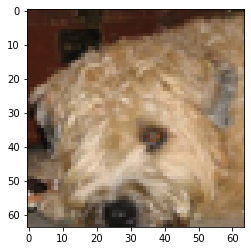

In [310]:
X_train = normalize_image(X_train)
plt.imshow(denormalize_image(X_train[0]))

In [311]:
X_train.shape

(1200, 64, 64, 3)

In [82]:
datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    preprocessing_function = lambda X: (X-127.5)/127.5
)
data_loader=datagen.flow_from_directory(
    PATH_TRAIN_IMAGE,
    target_size = SHAPE_IMAGE[:-1], 
    class_mode = None,
    batch_size = BATCH_SIZE)

Found 20580 images belonging to 120 classes.


In [83]:
# returns numbers between .7 and 1.2
# this will then be multipled by the label 1.0 to smooth it over
def label_smooth_factor(size):
    return np.random.rand(size)/2 + .7

In [285]:
# Switches Some images to the oposite group
def swap_group(prob_flip,size,real_images_batch,fake_images_batch):
    for i in range(size):
        flip = np.random.rand()
        if(flip<prob_flip):
            holder = real_images_batch[i]
            real_images_batch[i] = fake_images_batch[i]
            fake_images_batch[i] = holder
    return real_images_batch, fake_images_batch

In [286]:
def generate_real_samples(n_samples):
    return next(data_loader)[:n_samples], np.reshape(np.ones(n_samples)*label_smooth_factor(n_samples),(n_samples,1))

In [287]:
def generate_real_samples2(batch_size):
    image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
    y_valid = np.reshape(np.ones(batch_size)*label_smooth_factor(batch_size),(batch_size, 1))
    return (image_batch, y_valid)

In [288]:
x, y = generate_real_samples(32)

In [289]:
x2, y2 = generate_real_samples2(32)

In [290]:
y.shape

(32, 1)

In [291]:
y2.shape

(32, 1)

In [292]:
def show_images(ary, rows, cols):
    plt.figure(figsize=(cols*3, rows*3))
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, row*cols+col+1)
            img = (ary[row*cols+col, :] + 1) / 2
            plt.axis('off')
            plt.title(f'{row*cols+col}')
            plt.imshow(img)
    plt.show()

In [293]:
n_samples = 1000

In [294]:
# X_train, y = generate_real_samples(n_samples)

In [295]:
X_train.shape

array([[[[-8.73964131e-01, -8.27450991e-01, -9.17203188e-01],
         [-8.88635039e-01, -8.48638833e-01, -9.00380731e-01],
         [-8.69712710e-01, -8.10013711e-01, -9.18522537e-01],
         ...,
         [-8.66666675e-01, -7.64705896e-01, -8.98039222e-01],
         [-8.66666675e-01, -7.64705896e-01, -8.98039222e-01],
         [-8.66666675e-01, -7.64705896e-01, -8.98039222e-01]],

        [[-8.72059226e-01, -8.27450991e-01, -9.01964128e-01],
         [-8.84825289e-01, -8.42924237e-01, -9.06095386e-01],
         [-8.75427365e-01, -8.21442962e-01, -9.12807941e-01],
         ...,
         [-8.61793458e-01, -7.58858085e-01, -8.90242159e-01],
         [-8.52269053e-01, -7.47428715e-01, -8.75003040e-01],
         [-8.42744648e-01, -7.35999465e-01, -8.59763980e-01]],

        [[-8.70154321e-01, -8.27450991e-01, -8.86725068e-01],
         [-8.81015539e-01, -8.37209523e-01, -9.11810040e-01],
         [-8.81142020e-01, -8.32872272e-01, -9.07093287e-01],
         ...,
         [-8.25971425e-0

shape of data: (5, 64, 64, 3)
min, max of data: -1.0 1.0
shape of y (5, 1)
min, max of y 0.7336115920439364 1.140269441144017
head 5 of y [[0.73361159]
 [0.81501846]
 [0.74272676]
 [1.14026944]
 [1.05997025]]


IndexError: index 5 is out of bounds for axis 0 with size 5

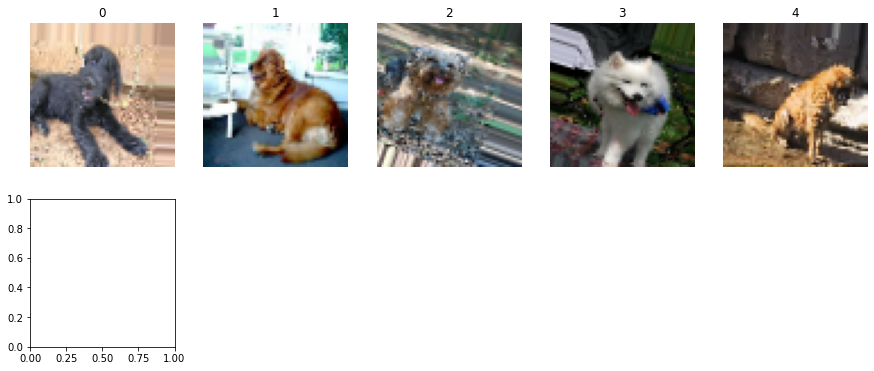

In [312]:
data, y = generate_real_samples(5)
print('shape of data:', data.shape) # => (32, 64, 64, 3)
print('min, max of data:', data.min(), data.max()) # => 0.0 1.0
print('shape of y', y.shape) # => (32, 1)
print('min, max of y', y.min(), y.max()) # => 1.0 1.0
print('head 5 of y', y[:5]) # => [[1.] [1.] ...]

show_images(data,2, 5)

In [313]:
def define_discriminator():
    model = Sequential([
        InputLayer(input_shape=SHAPE_IMAGE),
        
        Conv2D(32, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(256, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(512, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [314]:
# compile discriminator
discriminator = define_discriminator()
discriminator_opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_opt)
discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 8, 8, 128)       

In [315]:
def define_generator():
    model = Sequential([
        Dense((64*8*8), input_shape=(latent_dim,)),
        Reshape((8,8,64)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 16x16
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 32x32
        UpSampling2D(),
        Conv2D(32, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 64x64
        UpSampling2D(),
        Conv2D(16, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2D(3, kernel_size=3, padding='same'),
        Activation('tanh'),
    ])
    
    return model

In [316]:
# make generator
generator = define_generator()
generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4096)              413696    
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 16, 16, 64)      

In [317]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    noise = np.random.normal(0.0, 1.0, (n_samples, latent_dim))
    return noise

In [318]:
def generate_latent_noise(latent_dim, batch_size):
    return np.random.randn(batch_size, latent_dim)

In [319]:
noise1 = generate_noise(32)
print(noise1)

[[ 0.33037606 -1.159662   -0.01297485 ...  1.1893087   1.07246611
   0.17872158]
 [-1.79299292 -1.49964572  0.24394764 ...  0.97312291  0.28345634
   0.56413341]
 [-1.34239614  0.81724131  0.73473314 ... -0.5060014   0.73642923
  -1.5078201 ]
 ...
 [-0.31370019 -1.20011442  0.31842469 ... -2.08345196  0.07980046
  -0.56463865]
 [ 0.39498232  0.47440488 -0.25554043 ... -1.29666093  1.00317336
   0.56603202]
 [-0.2708384  -0.4364114  -0.30958814 ... -0.405137    0.65616871
  -0.91766948]]


In [320]:
noise2 = generate_latent_points(latent_dim, 32)
print(noise2)

[[ 1.50991281 -0.46046265 -1.40706651 ...  1.21833022 -0.26502875
  -0.54228655]
 [-0.16266025 -1.67483182 -0.22284369 ... -1.22396635 -0.22231768
  -1.16036058]
 [-0.31269918  0.37152497  0.04147828 ... -0.83475963  0.88209147
   0.19486564]
 ...
 [ 0.79058821 -0.13099495 -0.34825    ...  0.7885166  -0.14798766
  -1.15834788]
 [-0.53037064 -0.1585406  -0.01406331 ...  1.05592028 -1.39954369
  -1.27882137]
 [ 0.24064743  1.19997364 -2.36293209 ... -0.37845989 -1.28461087
  -1.05446602]]


In [321]:
noise2.shape

(32, 100)

In [322]:
noise1.shape

(32, 100)

In [335]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    
    # generate the latent noise or x values for input
    x_input = generate_latent_noise(latent_dim, n_samples)
    
    # pass the latent noise into the generator model to produce X values
    X = g_model.predict(x_input)
    
    # generate col of y=1 values for the fake images as a classifier
    y = np.zeros((n_samples, 1))
    return X, y

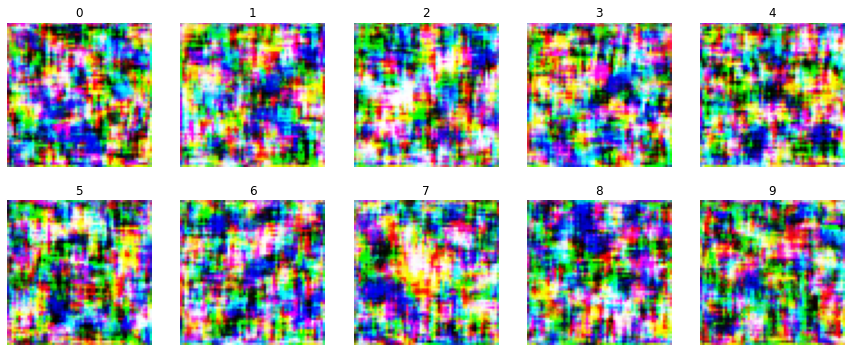

In [336]:
# generator output test
X, y = generate_fake_samples(generator, latent_dim, 10)
show_images(X, 2, 5)

In [325]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    d_model_fixed = Model(inputs=d_model.inputs, outputs=d_model.outputs)
    d_model_fixed.trainable = False
    # connect them
    model = Sequential([
        InputLayer(input_shape=(latent_dim,)),
        g_model,
        d_model_fixed
    ])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [326]:
gan = define_gan(generator, discriminator)
gan.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 64, 64, 3)         474851    
_________________________________________________________________
model_4 (Model)              (None, 1)                 1574593   
Total params: 2,049,444
Trainable params: 474,499
Non-trainable params: 1,574,945
_________________________________________________________________


In [327]:
def train_discriminator(batch_size=32):
    # get random real samples, half batch size
    X_real, y_real = generate_real_samples2(batch_size//2)
    
    # get fake examples, half batch size
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, batch_size//2)
    
#     image_batch, generated_images = swap_group(.025,batch_size//2,X_real,X_fake)
    
    loss_real = discriminator.train_on_batch(X_real, y_real)
    loss_fake = discriminator.train_on_batch(X_fake, y_fake)
    
    return (loss_real+loss_fake)*0.5

In [328]:
def train_gan(batch_size=32):
    # prepare points in latent space as input for the generator
    X = generate_latent_noise(latent_dim, batch_size)
    # create inverted labels for the fake samples
    y = np.reshape(np.ones(batch_size)*label_smooth_factor(batch_size),(batch_size,1))
    loss = gan.train_on_batch(X, y)
    return loss

In [329]:
# # train all
# history = np.zeros((num_epoch, num_batch, 2))
# dogs_at_epoch = np.zeros((num_epoch, *SHAPE_IMAGE))

# for i in tqdm(range(num_epoch), desc='epoch'):
#     data_loader.reset()
#     pbar_batch = tqdm(range(num_batch), desc='batch')
    
#     for j in pbar_batch:
#         d_loss = train_discriminator()
#         g_loss = train_gan()
#         pbar_batch.set_description(f'{i:>2}, d_loss:{d_loss:.2}, g_loss:{g_loss:.2}')
#         history[i, j, :] = d_loss, g_loss
        
#     generated_imgs = generate_fake_samples(generator, latent_dim, 5)[0]
#     show_images(generated_imgs, 1, 5)
#     dogs_at_epoch[i, :] = generated_imgs[0,:]

In [330]:
def CURRtrain(epochs=5, batch_size=32):
    save_dogs_each_epoch = np.zeros((num_epoch, *SHAPE_IMAGE))
    
    # setup number of batches for training
    batches = X_train.shape[0] / batch_size
    
    # loop through epochs
    for epoch in range(epochs):
        cum_generator_loss = 0
        cum_discriminator_loss = 0
        
        for i in range(int(batches)):
            d_loss = train_discriminator(batch_size)
            g_loss = train_gan(batch_size)
            cum_generator_loss += d_loss
            cum_discriminator_loss += g_loss
        
            print('>%d, %d/%d, d=%.3f, g=%.3f, c=%.3f, c=%.3f' % (epoch+1, i, batches, d_loss, g_loss, cum_generator_loss, cum_discriminator_loss))
            
    generated_imgs = generate_fake_samples(generator, latent_dim, 5)[0]
    show_images(generated_imgs, 1, 5)
    save_dogs_each_epoch[epoch, :] = generated_imgs[0,:]
            

In [331]:
print(X_train.shape[0])

1200


In [332]:
X_train.shape

(1200, 64, 64, 3)

>1, 0/37, d=1.102, g=0.728, c=1.102, c=0.728
>1, 1/37, d=0.922, g=0.728, c=2.024, c=1.456
>1, 2/37, d=0.867, g=0.797, c=2.891, c=2.252
>1, 3/37, d=0.747, g=0.798, c=3.637, c=3.050
>1, 4/37, d=0.668, g=1.048, c=4.305, c=4.098
>1, 5/37, d=0.384, g=0.886, c=4.689, c=4.984
>1, 6/37, d=0.578, g=1.304, c=5.267, c=6.288
>1, 7/37, d=0.345, g=1.123, c=5.612, c=7.412
>1, 8/37, d=0.385, g=1.631, c=5.997, c=9.042
>1, 9/37, d=0.300, g=1.203, c=6.297, c=10.246
>1, 10/37, d=0.428, g=1.817, c=6.725, c=12.062
>1, 11/37, d=0.337, g=1.045, c=7.062, c=13.107
>1, 12/37, d=0.261, g=1.475, c=7.323, c=14.582
>1, 13/37, d=0.318, g=1.698, c=7.641, c=16.280
>1, 14/37, d=0.356, g=1.358, c=7.997, c=17.639
>1, 15/37, d=0.205, g=2.033, c=8.202, c=19.671
>1, 16/37, d=0.192, g=1.832, c=8.394, c=21.504
>1, 17/37, d=0.329, g=1.667, c=8.723, c=23.171
>1, 18/37, d=0.318, g=1.965, c=9.041, c=25.136
>1, 19/37, d=0.313, g=3.052, c=9.354, c=28.188
>1, 20/37, d=0.180, g=3.494, c=9.534, c=31.682
>1, 21/37, d=0.378, g=2.694, c=9

>5, 28/37, d=0.080, g=1.211, c=6.986, c=43.366
>5, 29/37, d=0.135, g=1.398, c=7.120, c=44.765
>5, 30/37, d=0.151, g=0.725, c=7.271, c=45.490
>5, 31/37, d=0.071, g=0.815, c=7.342, c=46.306
>5, 32/37, d=0.278, g=1.215, c=7.620, c=47.520
>5, 33/37, d=-0.046, g=0.977, c=7.573, c=48.497
>5, 34/37, d=0.127, g=1.290, c=7.700, c=49.788
>5, 35/37, d=0.222, g=1.233, c=7.922, c=51.021
>5, 36/37, d=0.204, g=1.058, c=8.127, c=52.079


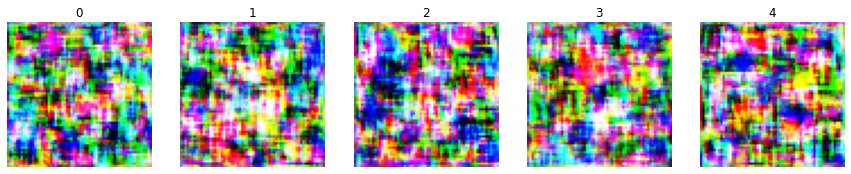

In [333]:
CURRtrain()

In [299]:
def training(epochs=1, batch_size=32):
    #Loading Data
    batches = X_train.shape[0] / batch_size
    
    # Adversarial Labels
    y_valid = np.ones(batch_size)*label_smooth_factor(batch_size)
    y_fake = np.zeros(batch_size)
    discriminator_loss, generator_loss = [], []

    for epoch in range(1, epochs+1):
        g_loss = 0; d_loss = 0

        for _ in range(int(batches)):
            # Random Noise and Images Set
            noise = generate_noise(batch_size)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate Fake Images
            generated_images = generator.predict(noise)
            
            #random swaps
            image_batch, generated_images = swap_group(.05,batch_size,image_batch,generated_images)
            
            # Train Discriminator (Fake and Real)
            discriminator.trainable = True
            d_valid_loss = discriminator.train_on_batch(image_batch, y_valid)
            d_fake_loss = discriminator.train_on_batch(generated_images, y_fake)            

            d_loss += (d_fake_loss + d_valid_loss)/2
            
            # Train Generator
            noise = generate_noise(batch_size)
            discriminator.trainable = False
            g_loss += gan.train_on_batch(noise, y_valid)
            
        discriminator_loss.append(d_loss/batches)
        generator_loss.append(g_loss/batches)
            
        if epoch % PLOT_FRECUENCY == 0:
            print('Epoch', epoch)
            plot_images(generator)
            plot_loss(epoch, generator_loss, discriminator_loss)


In [ ]:
# show_images(dogs_at_epoch[:, :, :, :], num_epoch//5, 5)
plt.plot(history[:,-1,:])

In [ ]:
# generate images
latent_points = generate_latent_noise(latent_dim, 10000)
# generate images
X = generator.predict(latent_points)

print(X.shape, X[0].min(), X[0].max())

In [ ]:
show_images(X, 2, 5)

In [ ]:
history[4,-1:,:]